In [1]:
import pandas as pd
import numpy as np

In [2]:
passengers = pd.read_csv('C:\\Users\\Андрей Клычев\\временные ряды\\international-airline-passengers.csv')
passengers = passengers.dropna()
passengers = passengers.rename(columns={passengers.columns[1]: 'Values'})

series_p = passengers.Values

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10, 7]

In [143]:
# 1. Скользящее среднее
def rolling_mean(series, n):
    dotes = []
    for _ in range(len(series)):
        try:
            
            dotes.append(series.loc[_:_+(n-1)].values.mean())
        except:
            pass
    return dotes

In [5]:
rolling_mean = pd.Series(rolling_mean(series_p, 4), name='rolling_mean')

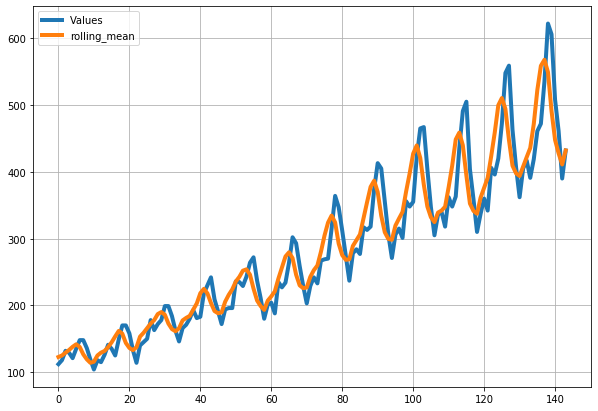

In [6]:
series_p.plot(linewidth='4')
rolling_mean.plot(linewidth='4')
plt.legend()
plt.grid()

In [7]:
import fibo
fibo.fib2(20)

[0, 1, 1, 2, 3, 5, 8, 13]

In [144]:
# 2. Взвешенная скользящая средняя
def weighted_mean(series, n, weights):
    dotes = []
    for _ in range(len(series)):
        try:
            arr = []
            a = series.loc[_:_+(n-1)].values
            for i in range(n):
                arr.append(a[i]*weights[i])
            
            dotes.append(sum(arr)/sum(weights))
        except:
#             print(f'{len(weights)} != {n}')
            break
            
    return dotes

In [9]:
fib = pd.Series(weighted_mean(series_p, 5, fibo.fib2(7)[1:]), name='fib_w_mean')
squares = pd.Series(weighted_mean(series_p, 5, [1, 4, 9, 16, 25]), name='square_w_mean')
naturals = pd.Series(weighted_mean(series_p, 5, [40 ,50, 60, 80, 120]), name='natural_w_mean')

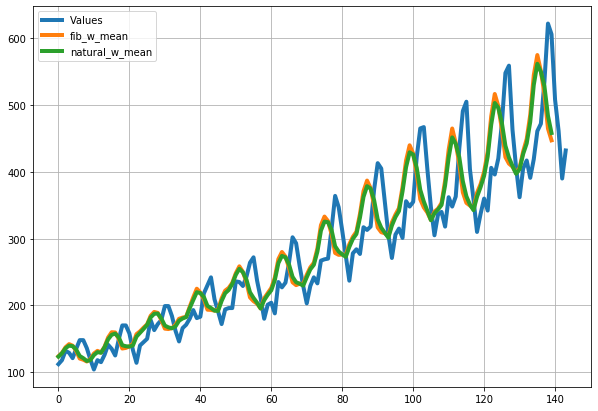

In [10]:
series_p.plot(linewidth='4')
fib.plot(linewidth='4')
naturals.plot(linewidth='4')
# rolling_mean.plot(linewidth='4')
plt.legend()
plt.grid()
    

In [145]:
# 3. Экспоненциальное сглаживание
def exponential_rolling(series, alpha, n):
    dotes = [series[0:(n-1)].mean()]
    
    for _ in range(n, (len(series))):
        try:
            
            dotes.append(series[_]*alpha + series[_-n:_-1].mean()*(1-alpha))
        except:
            raise
    return dotes

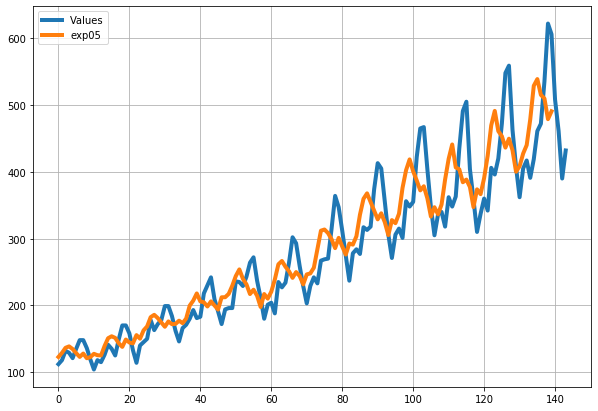

In [63]:
# exp09 = pd.Series(exponential_rolling(series_p, 0.9), name='exp09')

exp05 = pd.Series(exponential_rolling(series_p, 0.5, 5), name='exp05')
series_p.plot(linewidth='4')
# exp09.plot(linewidth='4')
exp05.plot(linewidth='4')
plt.grid()
plt.legend()
plt.show()

Использованные выше методы, не являются методами предсказания впринципе, поскольку они опираются, хоть и частично, на точки 
из ряда, который требуется предсказать

In [146]:
# 4. Тройное экспоненциальное сглаживание
def initial_trend(series, season_len):
    i = 1
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha=1, beta=1, gamma=1, ser=series_p, ser_to_plot=series_p, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

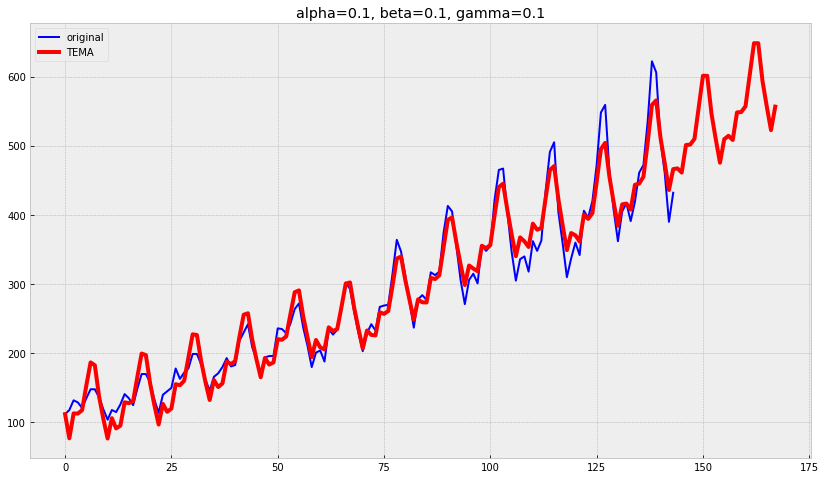

In [83]:
plot_tema(0.1, 0.1, 0.1)

In [121]:
train, val = series_p[:125], series_p[125:]

In [122]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize



def mse_cross_val(X, train=train):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_index, test_index in split.split(train): #Итерация производится по индексу
        train_split = train.iloc[train_index]
        test_split = train.iloc[test_index]


        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, n_preds=len(test_index))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))


In [123]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1375.2123624108056
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.27595761e-04,  1.68256520e-03, -3.64420885e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 17
   status: 0
  success: True
        x: array([0.95934059, 0.04225214, 1.        ])


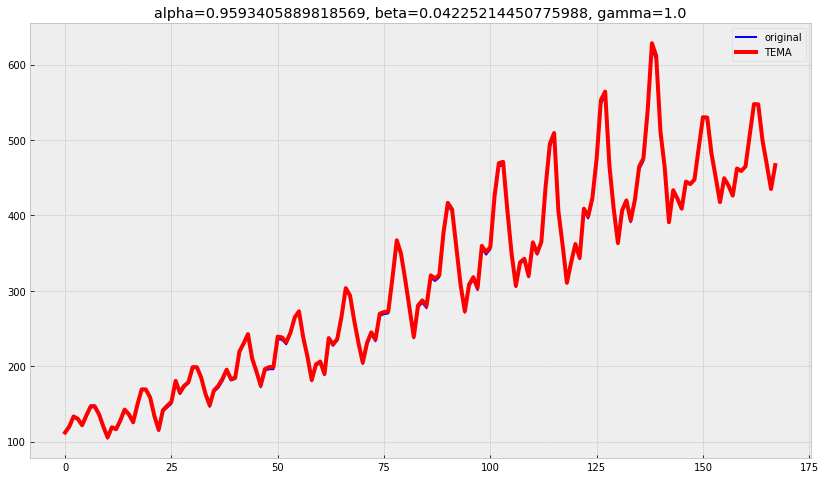

In [124]:
plot_tema(alpha_opt, beta_opt, gamma_opt)

In [ ]:
Совмещение отличное, последующие 

In [95]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox


def test_st(series):
    print('Результат теста Дики-Фуллера:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['результат Т-теста:', "Дов. интервал:", "Величина лага:", "Кол-во наблюдений:"])
    for key, value in dftest[4].items():
        print(f'Критическое значение {key}: ', value)
    print(dfoutput)
    
    
def tsplot(series, style='bmh'):
    test_st(series)
    
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    with plt.style.context(style):
        plt.figure()
        layout = (4, 1)
        
        timeseries_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        autocorfunc_ax = plt.subplot2grid(layout, (2, 0))
        partialautocorfunc_ax = plt.subplot2grid(layout, (3, 0))
        
        series.plot(ax = timeseries_ax)
        
        timeseries_ax.set_title('Временной ряд')
        
        
        smt.graphics.plot_acf(series, ax=autocorfunc_ax, alpha=0.05)
        smt.graphics.plot_pacf(series, ax=partialautocorfunc_ax, alpha=0.05)
        
        plt.tight_layout()

In [106]:
# new_series = boxcox(series_p, 0)
# new_series = new_series[11:] - new_series[:-11]
new_series = new_series[4:] - new_series[:-4]

Результат теста Дики-Фуллера:
Критическое значение 1%:  -3.486055829282407
Критическое значение 5%:  -2.8859430324074076
Критическое значение 10%:  -2.5797850694444446
результат Т-теста:     -3.761276
Дов. интервал:          0.003329
Величина лага:          8.000000
Кол-во наблюдений:    120.000000
dtype: float64


D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


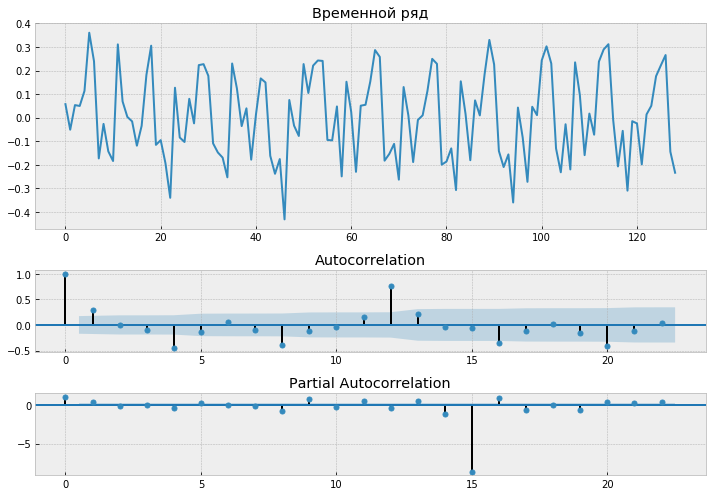

In [107]:
tsplot(new_series)

In [128]:
train, val = new_series[: int(0.75*len(new_series))], new_series[-int(0.25*len(new_series)):] 

In [129]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1375.2123624108056
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.27595761e-04,  1.68256520e-03, -3.64420885e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 17
   status: 0
  success: True
        x: array([0.95934059, 0.04225214, 1.        ])


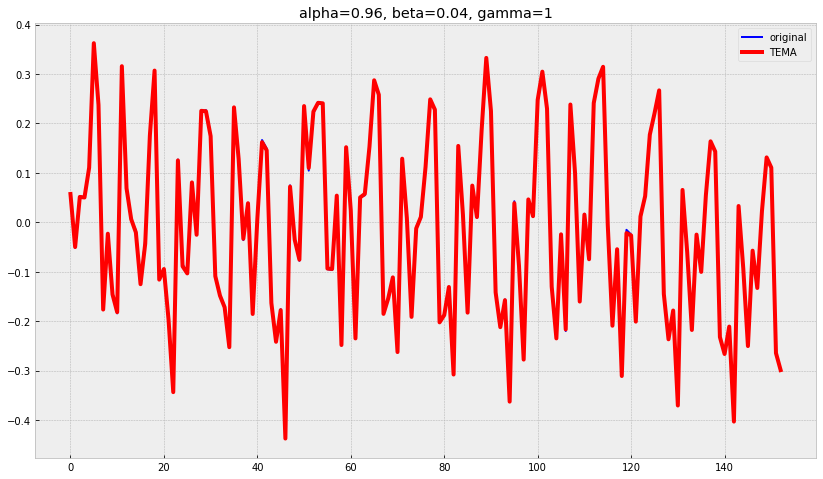

In [142]:
plot_tema(ser=new_series, ser_to_plot=new_series, alpha=0.96, beta=0.04, gamma=1)

Методом тройного экспоненциального сглаживания достигается отличный результат, особенно на стационарном ряду!